In [1]:
import json
import matplotlib.pyplot as plt
import os
import cv2

from src.model.srgan import SRGAN
from src.utils import check_GPU_is_available, get_tensor_from_path
from src.visualization import plot_imgs_in_row
from keras import config

check_GPU_is_available(is_required=False)

2024-03-24 15:13:40.881953: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 15:13:40.920330: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 15:13:41.611828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow was built with GPU support.
Num of visible GPU(s): 0
Device(s) name(s): []


2024-03-24 15:13:42.004841: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Load model

In [2]:
model_path = "./assets/finetuned/srgan_gen_div2k-bicubic_x4_1711239215_finetuned.keras"
generator = None

In [3]:
json_cfg_path = "./GPU_train_cfg.json"
train_cfg = json.load(open(json_cfg_path, 'r'))
config.enable_unsafe_deserialization()
try:
    scaling_factor = train_cfg["dataset"]["SCALING_FACTOR"]
    feature_maps = train_cfg["srgan"]["FEATURE_MAPS"]
    residual_blocks = train_cfg["srgan"]["RES_BLOCKS"]
    print("[INFO] loading the pretrained SRGAN generator...")
    generator = SRGAN.generator(
            scaling_factor=scaling_factor,
            feature_maps=feature_maps,
            residual_blocks=residual_blocks)
    generator.load_weights(model_path)
    print("[INFO] pretrained SRGAN generator loaded!")
except Exception as e:
    print("[ERROR] error loading the pretrained SRGAN generator: {}".format(e))

[INFO] loading the pretrained SRGAN generator...
[INFO] pretrained SRGAN generator loaded!


## Load Sample

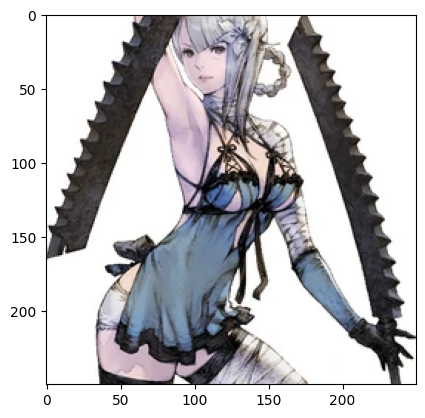

In [4]:
sample_path = "./example/Kaine.png"
img = plt.imread(sample_path)
resized_img = cv2.resize(img, (img.shape[1]*4, img.shape[0]*4), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)

## Upscale

In [5]:
tensor_in = get_tensor_from_path(sample_path)
print("tensor_in -> ", tensor_in.shape)
tensor_out = generator.predict(tensor_in)
print("tensor_out -> ",tensor_out.shape)
sr_image = tensor_out[0]/255.0

tensor_in ->  (1, 250, 250, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
tensor_out ->  (1, 1000, 1000, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


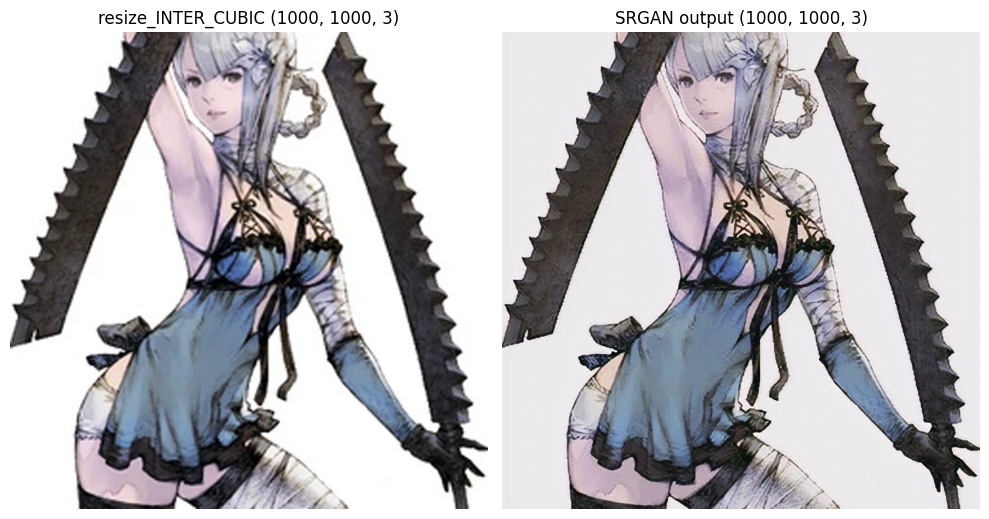

In [9]:
img_list = [(resized_img, f"resize_INTER_CUBIC {resized_img.shape}"), (sr_image, f"SRGAN output {sr_image.shape}")]
plot_imgs_in_row(img_list, figsize=(10, 10))

## Save SR-Image

In [7]:
save_path = f"./out/SR_{os.path.basename(sample_path)}"
plt.imsave(save_path, tensor_out[0]/255.0)